Neste notebook verificamos como o modelo OMD sexuado se comporta em diferentes casos, variando $\sigma_A$, valores iniciais e $\sigma_f$.

In [1]:
#Importando bibliotecas
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint, quad, dblquad
from scipy.integrate import trapezoid as trapz
import warnings

In [2]:
#Definindo funções
def normal(z, zbar, V):
    return 1 / np.sqrt(2*np.pi*V) * np.exp(-(z-zbar)**2/(2*V))

def densidade(z, x, qtdz):
    soma = 0
    for j in range(qtdz):
        soma += x[1+j] * normal(z, x[1+2*qtdz+j], x[1+qtdz+j])
    return x[0] * soma

In [4]:
#Definindo modelo OMD sexuado
def roda_modelo_OMD(b0, s, d0, w, sigmaA, sigmaf, qtdz, VM, xmax, x0):
    def phi(x, cond):
        soma = 0
        for i in range(qtdz):
            soma += cond[i+1]*1/(np.sqrt(2*np.pi*cond[i+1+qtdz]))* \
                    np.exp(-(x-cond[i+1+2*qtdz])**2/(2*cond[i+1+qtdz]))
        return cond[0]*soma
    def dphidx(x, cond):
        soma = 0
        for i in range(qtdz):
            soma += - cond[i+1]*(x-cond[i+1+2*qtdz])/(np.sqrt(2*np.pi*cond[i+1+qtdz])*cond[i+1+qtdz])*\
                    np.exp(-(x-cond[i+1+2*qtdz])**2/(2*cond[i+1+qtdz]))
        return cond[0]*soma
    def d2phidx(x, cond):
        soma = 0
        for i in range(qtdz):
            soma += (cond[i+1] * ((x - cond[i+1+2*qtdz])**2 - cond[i+1+qtdz]) /
            (np.sqrt(2*np.pi*cond[i+1+qtdz])*cond[i+1+qtdz]**2) *
             np.exp(- (x-cond[i+1+2*qtdz])**2 / (2*cond[i+1+qtdz])))
        return cond[0]*soma

    def N(u, cond):
        soma = 0
        for i in range(qtdz):
            f = cond[1+i]
            V = cond[1+i+qtdz]
            z = cond[1+i+2*qtdz]
            soma += (f * np.exp((2*V*(u - z)**2/(2*V + sigmaA**2) - u**2 + 2*u*z - z**2) / 
                                sigmaA**2) / np.sqrt(2*V + sigmaA**2) / (2 * np.pi * sigmaA))
        return soma * cond[0] + np.finfo(np.float64).smallest_normal

    def beta(x, cond):
        epsabs = 1.49e-06
        epsrel=1.49e-02
        return (quad(lambda uu: phi(uu, cond) / N(uu, cond) * intdentro(x, uu, cond), -xmax-2*sigmaA, x-2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * intdentro(x, uu, cond), x-2*sigmaA, x + 2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * intdentro(x, uu, cond), x+2*sigmaA, xmax+2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0])
    def dbeta(x, cond):
        epsabs = 1.49e-06
        epsrel=1.49e-02
        return (quad(lambda uu: phi(uu, cond) / N(uu, cond) * dintdentro(x, uu, cond), -xmax-2*sigmaA, x-2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * dintdentro(x, uu, cond), x-2*sigmaA, x + 2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * dintdentro(x, uu, cond), x+2*sigmaA, xmax+2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0])
    def d2beta(x, cond):
        epsabs = 1.49e-06
        epsrel=1.49e-02
        return (quad(lambda uu: phi(uu, cond) / N(uu, cond) * d2intdentro(x, uu, cond), -xmax-2*sigmaA, x-2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * d2intdentro(x, uu, cond), x-2*sigmaA, x + 2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * d2intdentro(x, uu, cond), x+2*sigmaA, xmax+2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0])
    
    def c(x):
        return np.exp(-x**2/(2*w**2))
    def cd1(x):
        return -x*np.exp(-x**2/(2*w**2))/w**2
    def cd2(x):
        return (x**2 - w**2)*np.exp(-x**2/(2*w**2))/w**4

    def b(x):
        return b0 - s*x**2
    def bd1(x):
        return - 2*s*x
    def bd2(x):
        return - 2*s

    def d(x, cond):
        soma = 0
        for i in range(qtdz):
            soma += cond[i+1]*c(cond[i+1+2*qtdz]-x)
        return d0 + cond[0]*soma
    def dd1(x, cond):
        soma = 0
        for i in range(qtdz):
            soma += cond[i+1]*(-cd1(cond[i+1+2*qtdz]-x))
        return cond[0]*soma
    def dd2(x, cond):
        d2soma = 0
        for i in range(qtdz):
            d2soma += cond[i+1]*cd2(cond[i+1+2*qtdz]-x)
        return cond[0]*d2soma

    def intdentro(x, u, cond):
        soma = 0
        for i in range(qtdz):
            f = cond[1+i]
            V = cond[1+i+qtdz]
            z = cond[1+i+2*qtdz]
            soma += ( f * np.sqrt(4*V + 2*sigmaA**2) * np.exp(2*sigmaf**2*(-4*V*u + 4*V*x - sigmaA**2*u +
                    2*sigmaA**2*x - sigmaA**2*z)**2/(V**2*sigmaA**4 + 8*V**2*sigmaA**2*sigmaf**2 +
                    4*V*sigmaA**4*sigmaf**2) - 4*u**2/sigmaA**2 + 8*u*x/sigmaA**2 - 4*x**2/sigmaA**2 -
                    u**2/(2*V) + 2*u*x/V - u*z/V - 2*x**2/V + 2*x*z/V - z**2/(2*V)) /
                    (2*np.pi**(3/2)*sigmaA*np.sqrt(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 
                    16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)) )
        return soma * cond[0]
    def dintdentro(x, u, cond):
        from numpy import sqrt, exp, pi
        soma = 0
        for i in range(qtdz):
            f = cond[1+i]
            V = cond[1+i+qtdz]
            z = cond[1+i+2*qtdz]
            soma += f * (sqrt(2)*(2*V + sigmaA**2)**(3/2)*
                         (4*V*u - 4*V*x + sigmaA**2*u - 2*sigmaA**2*x + sigmaA**2*z) *
                         exp(-(4*V*(u**2 - 2*u*x + x**2) + sigmaA**2*
                               (u**2 - 4*u*x + 2*u*z + 4*x**2 - 4*x*z + z**2)/2 -
                               2*sigmaf**2*(4*V*u - 4*V*x + sigmaA**2*(u - 2*x + z))**2/
                               (V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))/
                             (V*sigmaA**2))/(pi**(3/2)*sigmaA*(2*V**2*sigmaA**2 + 
                                        16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 
                                        4*sigmaA**4*sigmaf**2)**(3/2)))
        return cond[0] * soma
    def d2intdentro(x, u, cond):
        from numpy import sqrt, exp, pi
        soma = 0
        for i in range(qtdz):
            f = cond[1+i]
            V = cond[1+i+qtdz]
            z = cond[1+i+2*qtdz]
            soma += f * ( sqrt(4*V**2*sigmaA**2 + 32*V**2*sigmaf**2 + 2*V*sigmaA**4 + 32*V*sigmaA**2*sigmaf**2 + 
                               8*sigmaA**4*sigmaf**2)*
                         (V**2*sigmaA**4*(2*V + sigmaA**2)**2 + 8*V**2*sigmaA**2*sigmaf**2*(2*V + sigmaA**2)**2 + 
                          4*V*sigmaA**4*sigmaf**2*(2*V + sigmaA**2)**2 + 4*sigmaf**2*(2*V + sigmaA**2)**2*
                          (4*V*u - 4*V*x + sigmaA**2*u - 2*sigmaA**2*x + sigmaA**2*z)**2 - 
                          (2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 
                           4*sigmaA**4*sigmaf**2)**2)*
                         exp((4*sigmaf**2*(4*V*u - 4*V*x + sigmaA**2*(u - 2*x + z))**2 - 
                              (8*V*(u**2 - 2*u*x + x**2) + sigmaA**2*(u**2 - 4*u*x + 2*u*z + 4*x**2 - 4*x*z + z**2))*
                              (V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))/
                             (2*V*sigmaA**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)))/
                         (2*pi**(3/2)*sigmaA*sigmaf**2*(2*V + sigmaA**2)**(5/2)*
                          (V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**3))
        return cond[0] * soma

    def r(x, cond):
        return beta(x, cond)*b(x)/phi(x, cond) - d(x, cond)
    def rd1(x, cond):
        return (phi(x, cond)*beta(x, cond)*bd1(x) + b(x)*phi(x, cond)*dbeta(x, cond) - 
                b(x)*beta(x, cond)*dphidx(x, cond))/phi(x, cond)**2 - dd1(x, cond)
    def rd2(x, cond):
        return (phi(x, cond) * (-beta(x, cond)*b(x)*d2phidx(x, cond)  - 2 * dphidx(x, cond) * 
                                (beta(x, cond)*bd1(x) + b(x)*dbeta(x, cond)) ) +
                phi(x, cond)**2 * (beta(x, cond)*bd2(x) + 2*bd1(x)*dbeta(x, cond) + b(x)*d2beta(x, cond)) + 
                2*b(x)*beta(x, cond)*dphidx(x, cond)**2)/phi(x, cond)**3 - dd2(x, cond)
    def Somafrzbarra(cond):
        soma = 0
        for i in range(qtdz):
            soma += cond[i+1]*r(cond[i+1+2*qtdz], cond)
        return soma

    def eq(t, cond):
        ret = np.zeros_like(cond)
        if any(cond[0:5] < 0):
            raise(ValueError(f"Valores negativos: t={t}, cond={cond}"))

        Somafrzb = Somafrzbarra(cond)
        soma = 0
        for i in range(qtdz):
            soma += cond[i+1]*cond[i+1+qtdz]*rd2(cond[i+1+2*qtdz], cond)
        ret[0] = (Somafrzb + soma/2)*cond[0]                                     #dn

        for j in range(1, qtdz+1):
            ret[j] = cond[j]*(r(cond[j + 2*qtdz], cond) - Somafrzb)              #df 
            ret[qtdz + j] = cond[qtdz+j]**2 * rd2(cond[2*qtdz + j], cond) + VM   #dV 
            ret[2*qtdz+j] = cond[qtdz+j]*rd1(cond[2*qtdz+j], cond)               #dz
        return ret
    
    y_omd = solve_ivp(eq, (0, temp), x0, method="Radau", t_eval=t, max_step = 0.5)
    
    return y_omd

## Dependencia da condição inicial

In [110]:
#Parâmetros

b0 = 1
s = 0.1
w = 2
d0 = 0.001
VM = 0
qtdz = 2
sigmaA = 1e-2
sigmaf = 1e-3
xmax = 3.
z = np.arange(-1.5, 1.5, 0.01)

#Tempo
temp = 50
t = np.arange(0, temp, 5)

#Condições iniciais
#n-0 f1-1 f2-2 V1-3 V2-4 z1barra-5 z2barra-6
vx0 = np.array([[1., 2/3, 1/3, 0.01, 0.01, 0.5, -0.5], [1., 2/3, 1/3, 0.01, 0.01, 0.4, -0.4], 
               [1., 2/3, 1/3, 0.01, 0.01, 0.3, -0.3], [1., 2/3, 1/3, 0.01, 0.01, 0.2, -0.2],
               [1., 2/3, 1/3, 0.01, 0.01, 0.1, -0.1]])

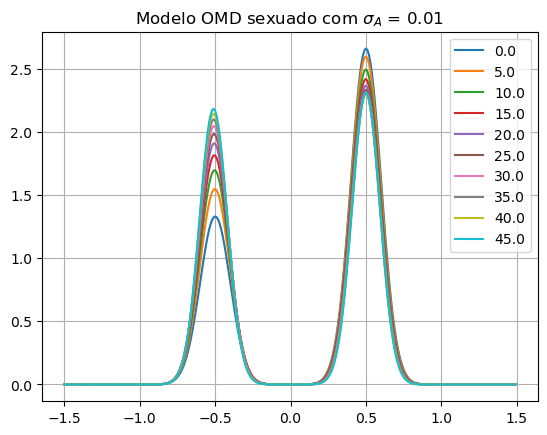

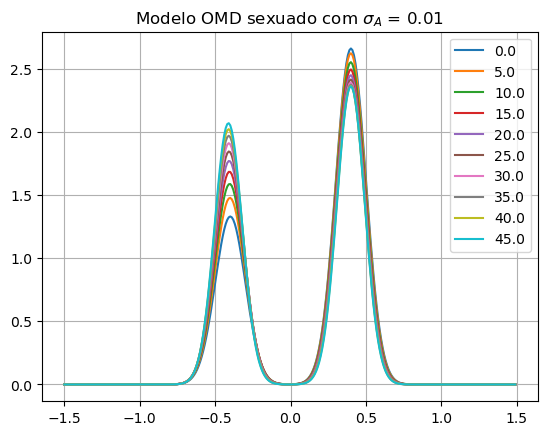

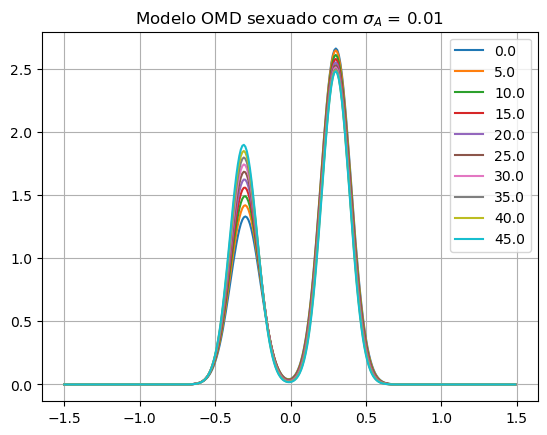

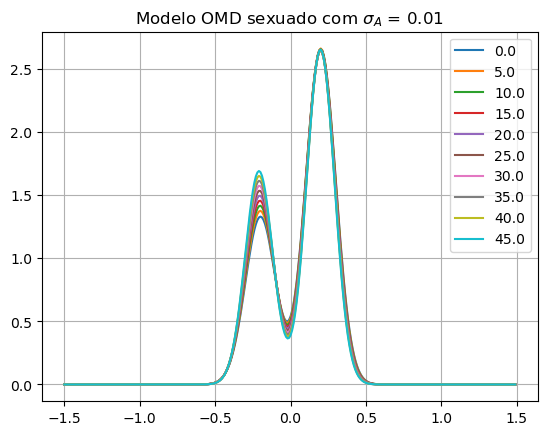

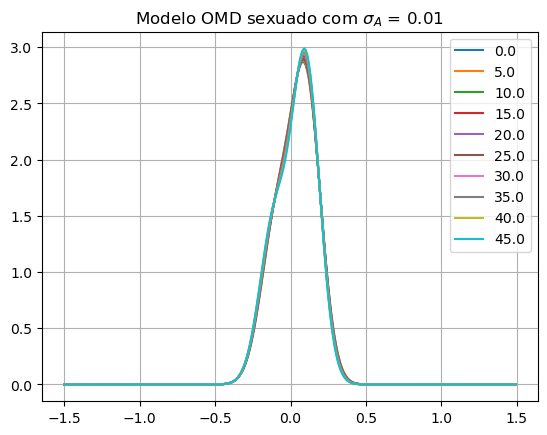

In [111]:
#Plotando gráficos
sigmaA = 1e-2
for x0 in vx0:
    y_omd = roda_modelo_OMD(b0, s, d0, w, sigmaA, sigmaf, qtdz, VM, xmax, x0)
    for i in range(0, len(y_omd.t), 1):
        plt.plot(z, densidade(z, y_omd.y[:,i], 2), label=f"{y_omd.t[i]:.1f}")
    plt.title("Modelo OMD sexuado com $\sigma_A$ = "+str(sigmaA))
    plt.legend()
    plt.grid()
    plt.show()

## Variando $\sigma_A$

In [5]:
#Parâmetros

b0 = 1
s = 0.1
w = 2
d0 = 0.001
VM = 0
qtdz = 2
vsigmaA = [1e-2, 5e-2, 1e-1, 5e-1, 1]
sigmaf = 1e-3
xmax = 3.
z = np.arange(-1.5, 1.5, 0.01)

#Tempo
temp = 50
t = np.arange(0, temp, 5)

#Condições iniciais
#n-0 f1-1 f2-2 V1-3 V2-4 z1barra-5 z2barra-6
x0 = np.array([1., 2/3, 1/3, 0.01, 0.01, 0.5, -0.5])

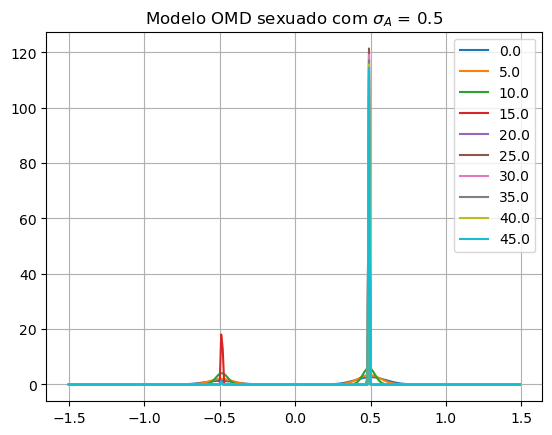

In [7]:
#Plotando gráficos (como descrito na tese, devido a rapida diminuição da variancia, 
#                    muitos erros numéricos ocorrem para maiores valores de sigmaA)
y_omd = roda_modelo_OMD(b0, s, d0, w, 0.05, sigmaf, qtdz, VM, xmax, x0)
for i in range(0, len(y_omd.t), 1):
    plt.plot(z, densidade(z, y_omd.y[:,i], 2), label=f"{y_omd.t[i]:.1f}")
plt.title(r"Modelo OMD sexuado com $\sigma_A$ = 0.5")
plt.legend()
plt.grid()
plt.show()

## Variando $\sigma_f$

Neste caso, quanto mais mutações ocorrem, mais rápido os picos vão decaindo

In [6]:
#Parâmetros

b0 = 1
s = 0.1
w = 2
d0 = 0.001
VM = 0
qtdz = 2
sigmaA = 1e-2
vsigmaf = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
xmax = 3.
z = np.arange(-1.5, 1.5, 0.01)

#Tempo
temp = 50
t = np.arange(0, temp, 5)

#Condições iniciais
#n-0 f1-1 f2-2 V1-3 V2-4 z1barra-5 z2barra-6
x0 = np.array([1., 2/3, 1/3, 0.01, 0.01, 0.5, -0.5])

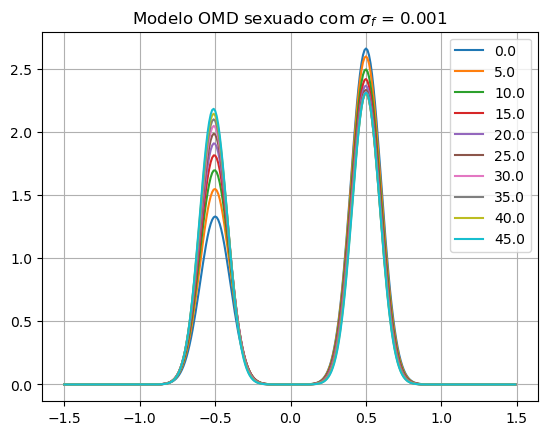

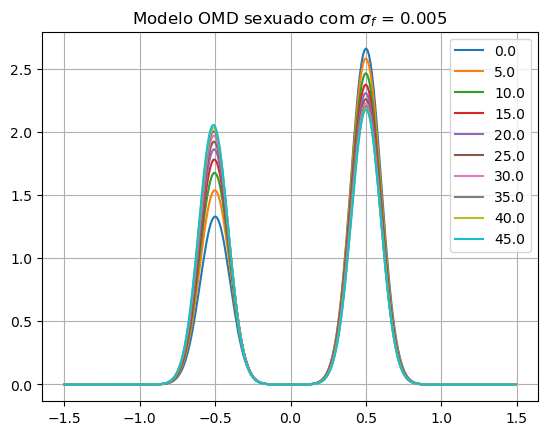

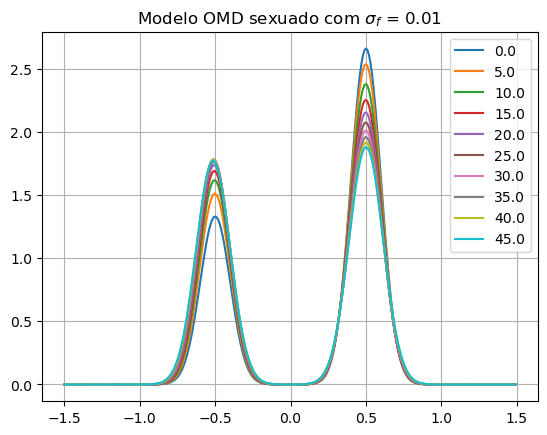

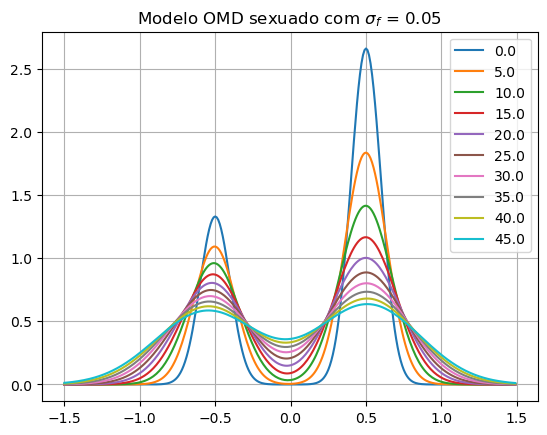

ValueError: Values in `t_eval` are not within `t_span`.

In [7]:
#Plotando gráficos (erro para último valor)
for sigmaf in vsigmaf:
    if sigmaf == 0.1:
        t = np.arange(0, 100, 5)
    y_omd = roda_modelo_OMD(b0, s, d0, w, sigmaA, sigmaf, qtdz, VM, xmax, x0)
    for i in range(0, len(y_omd.t), 1):
        plt.plot(z, densidade(z, y_omd.y[:,i], 2), label=f"{y_omd.t[i]:.1f}")
    plt.title("Modelo OMD sexuado com $\sigma_f$ = "+str(sigmaf))
    plt.legend()
    plt.grid()
    plt.show()